# Deep Learning with Custom Dataset

본 실습에서는 Tabular Data 형태의 임의의 데이터셋에 대해 PyTorch로 모델링 및 학습을 진행해보도록 하겠습니다. 이번 실습에서는 California Housing Data를 활용한 예시를 살펴보겠습니다.

Reference:
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* https://averdones.github.io/reading-tabular-data-with-pytorch-and-training-a-multilayer-perceptron/

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, random_split

from torchsummary import summary

In [2]:
# set manual random seed for random_split
torch.manual_seed(2023)

## Get Data

In [3]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

In [4]:
print(california_housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
# 전체 data
df = california_housing['frame']

In [6]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


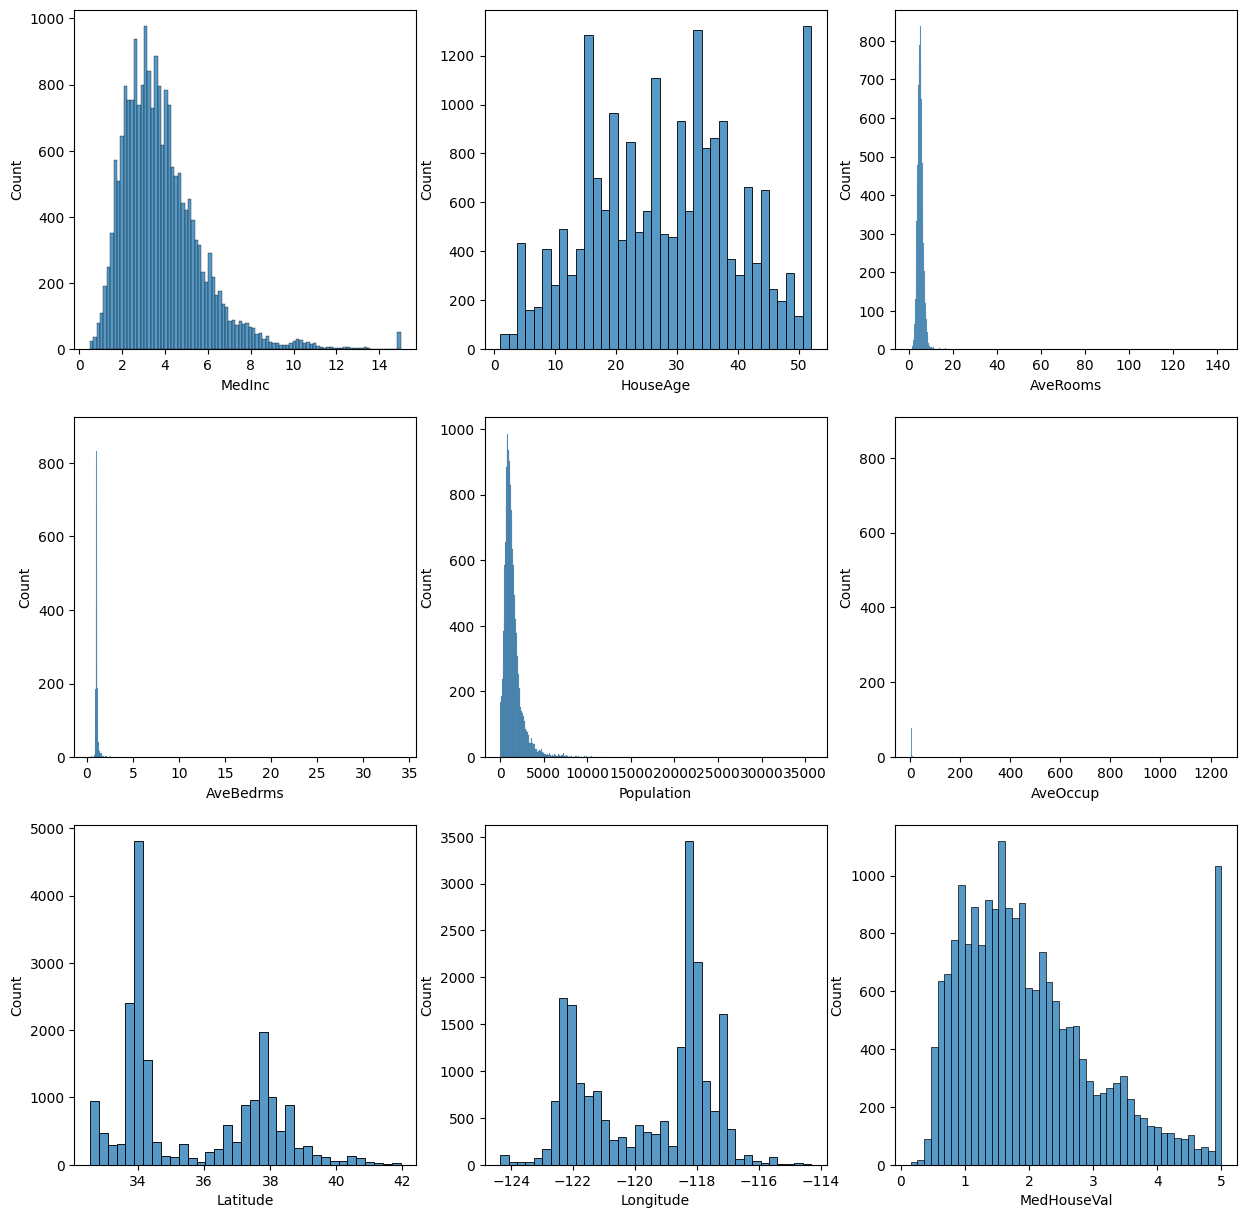

In [9]:
n_rows=3
n_cols=3

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
for i, column in enumerate(df.columns):
    sns.histplot(df[column],ax=axes[i//n_cols,i%n_cols])

In [10]:
# training에 사용되는 column
# same as df.iloc[:,:-1]
california_housing['data']

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [11]:
# 예측하고자 하는 label(`MedHouseVal`: median house value for California districts). 일종의 regression task!
# same as df.iloc[:,-1]
california_housing['target']

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422
...,...
20635,0.781
20636,0.771
20637,0.923
20638,0.847


In [12]:
X = california_housing['data']
y = california_housing['target']

## Create Custom Dataset

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
* `__init__`: initialize the Dataset object
* `__len__`: returns the number of samples in the dataset
* `__gettiem__`: loads and returns a sample from the dataset at the given index `idx`

In [13]:
class HousingDataset(Dataset):

    def __init__(self, X , y) :
        self.X = X
        self.y = y

    def __len__(self) :
        return len(self.X)

    def __getitem__(self,idx) :

        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [self.X.iloc[idx].values, self.y[idx]]

In [14]:
dataset = HousingDataset(X, y)

In [15]:
test_size = 0.2

In [16]:
test_len = int(test_size * len(dataset))
train_len = len(dataset) - test_len

In [17]:
# split train, test dataset with random_split
trainset, testset = random_split(dataset, [train_len, test_len])

In [18]:
testset[1]

[array([   4.625     ,   44.        ,    6.16309013,    1.10300429,
         745.        ,    3.19742489,   33.86      , -118.14      ]),
 2.134]

In [19]:
batch_size = 100

In [20]:
# load dataset to DataLoader
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

이 밖에도 `torch.utils.data.TensorDataset`을 활용하는 방법, numpy array 형태로 data 변환 후 tensor로 직접 변환해주는 방법 등 다양한 방법이 존재합니다. 본인에게 편한 방법을 찾아서 활용하면 됩니다!

## Build Neural Network

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Remeber: number of columns was 8
        self.fc1 = nn.Linear(8, 2**8)
        self.bn1 = nn.BatchNorm1d(2**8)
        self.fc2 = nn.Linear(2**8, 2**6)
        self.bn2 = nn.BatchNorm1d(2**6)
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(2**6, 2**5)
        self.fc4 = nn.Linear(2**5, 1)


    def forward(self, x):
        x = x.to(torch.float32)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x.squeeze()

In [23]:
net = Net()

In [24]:
net = net.to(device)

In [25]:
summary(net, (8,), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 256]           2,304
       BatchNorm1d-2                 [100, 256]             512
            Linear-3                  [100, 64]          16,448
       BatchNorm1d-4                  [100, 64]             128
           Dropout-5                  [100, 64]               0
            Linear-6                  [100, 32]           2,080
            Linear-7                   [100, 1]              33
Total params: 21,505
Trainable params: 21,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.56
Params size (MB): 0.08
Estimated Total Size (MB): 0.65
----------------------------------------------------------------


In [26]:
loss = nn.MSELoss()

In [27]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train model

In [28]:
num_epochs = 100

In [29]:
net.fc1.weight.dtype

torch.float32

In [30]:
loss_per_iter = []
loss_per_epoch = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    # set train mode
    net.train()

    # training
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        # net의 data 형태를 맞춰주어야 함
        l = loss(outputs.to(torch.float32), labels.to(torch.float32))

        # zero the parameter gradients
        optimizer.zero_grad()

        l.backward()

        optimizer.step()

        running_loss += l.item()
        loss_per_iter.append(l.item())

    loss_per_epoch.append(running_loss / len(trainloader))

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} / {num_epochs},  Train loss: {running_loss / len(trainloader)}")

    running_loss = 0.0

Epoch 5 / 100,  Train loss: 0.6090267298810453
Epoch 10 / 100,  Train loss: 0.5257813595684178
Epoch 15 / 100,  Train loss: 0.5060415761657509
Epoch 20 / 100,  Train loss: 0.4647019870848541
Epoch 25 / 100,  Train loss: 0.45179774163358183
Epoch 30 / 100,  Train loss: 0.4859955516385745
Epoch 35 / 100,  Train loss: 0.4436941264444087
Epoch 40 / 100,  Train loss: 0.4407646859805268
Epoch 45 / 100,  Train loss: 0.4354529963379883
Epoch 50 / 100,  Train loss: 0.4291750584022108
Epoch 55 / 100,  Train loss: 0.41381906412811165
Epoch 60 / 100,  Train loss: 0.42568923272641307
Epoch 65 / 100,  Train loss: 0.4193501470677824
Epoch 70 / 100,  Train loss: 0.416579352355147
Epoch 75 / 100,  Train loss: 0.41698871696569834
Epoch 80 / 100,  Train loss: 0.4038765065102692
Epoch 85 / 100,  Train loss: 0.40543219653597795
Epoch 90 / 100,  Train loss: 0.406528709164585
Epoch 95 / 100,  Train loss: 0.3975651669035475
Epoch 100 / 100,  Train loss: 0.3956251093242542


### Check the results

In [31]:
net.eval()

dataiter = iter(testloader)
inputs, labels = next(dataiter)
inputs = inputs.to(device)
labels = labels.type(torch.LongTensor).to(device)
outputs = net(inputs.float())

In [32]:
print("Root mean squared error")
print("Training:", np.sqrt(loss_per_epoch[-1]))
print("Test", np.sqrt(loss(outputs, labels.float()).detach().cpu().numpy()))

Root mean squared error
Training: 0.6289873681754302
Test 0.86482036


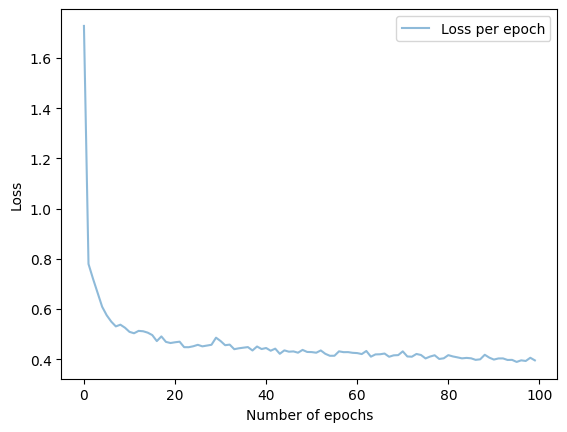

In [33]:
plt.plot(np.arange(len(loss_per_epoch)), loss_per_epoch, "-", alpha=0.5, label="Loss per epoch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()